In [1]:
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.7.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.8.1+cu101)
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.21)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-ao0fzf5w
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-ao0fzf5w
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-xxo0lu69
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-xxo0lu69
  Created wheel for fvcore: filename=fvcore-0.1.2-cp36-none-any.whl size=48589 sha256=a69ec2150930039d9821a75ad2a759862e68675c0c5d871bd76e3a439d103a51
  Stored in directory: /tmp/pip-ephem-wheel-cache-an46dw1_/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pycocotools: filename=pycocotools-2.0-

In [16]:
!nvidia-smi

Thu Dec 10 13:18:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    31W /  70W |   3223MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch, torchvision
import numpy as np
import pandas as pd
import random
import json
import cv2
import os

import detectron2
import detectron2.data.transforms as T
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
setup_logger()

import itertools
from itertools import groupby
from google.colab.patches import cv2_imshow

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskutil
from pycocotools import mask as maskUtils

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load data

In [4]:
# register training and test datasets to Detectron2
register_coco_instances("T", {}, "/content/gdrive/My Drive/pascal_train.json", "/content/gdrive/My Drive/train_images")
register_coco_instances("V", {}, "/content/gdrive/My Drive/test.json", "/content/gdrive/My Drive/test_images")

# metadata
train_metadata = MetadataCatalog.get("T")
test_metadata = MetadataCatalog.get("V")

# dataset dictionary
train_dataset_dicts = DatasetCatalog.get("T")
test_dataset_dicts = DatasetCatalog.get("V")

[12/10 11:19:02 d2.data.datasets.coco]: Loading /content/gdrive/My Drive/pascal_train.json takes 1.27 seconds.
[12/10 11:19:02 d2.data.datasets.coco]: Loaded 1349 images in COCO format from /content/gdrive/My Drive/pascal_train.json
[12/10 11:19:02 d2.data.datasets.coco]: Loaded 100 images in COCO format from /content/gdrive/My Drive/test.json


# Data augmetation

In [ ]:
# Augmetation function
def build_sem_seg_train_aug(cfg):
  augs = [T.RandomBrightness(0.5, 2),
    T.RandomContrast(0.5, 2),
    T.RandomSaturation(0.5, 2),
    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    T.RandomFlip(prob=0.5, horizontal=False, vertical=True)]
  return augs

# Custom trainer
class Trainer(DefaultTrainer):
  @classmethod
  def build_train_loader(cls, cfg):
    mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))
    return build_detection_train_loader(cfg, mapper=mapper)

# Set hyperparameters

In [8]:
cfg = get_cfg()

# load ImageNet pretrained weights
# cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")

# load dataset
cfg.DATASETS.TRAIN = ("T")

# parameters
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 20000                       
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20

# Traning

In [10]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/10 11:20:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-101.pkl: 179MB [00:08, 21.2MB/s]                           


[12/10 11:20:25 d2.checkpoint.c2_model_loading]: Remapping C2 weights ......
[12/10 11:20:25 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.bias            loaded from res2_0_branch2a_bn_beta           of shape (64,)
[12/10 11:20:25 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.running_mean    loaded from res2_0_branch2a_bn_running_mean   of shape (64,)
[12/10 11:20:25 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.running_var     loaded from res2_0_branch2a_bn_running_var    of shape (64,)
[12/10 11:20:25 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.weight          loaded from res2_0_branch2a_bn_gamma          of shape (64,)
[12/10 11:20:25 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.weight               loaded from res2_0_branch2a_w                 of shape (64, 64, 1, 1)
[12/10 11:20:25 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv2.norm.bias         

/content/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/detectron2_repo/detectron2/modeling/roi_heads/fast_rcnn.py:225: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg

[12/10 11:20:37 d2.utils.events]:  eta: 1:40:18  iter: 19  total_loss: 4.072  loss_cls: 2.633  loss_box_reg: 0.003618  loss_mask: 0.6931  loss_rpn_cls: 0.6875  loss_rpn_loc: 0.02957  time: 0.3549  data_time: 0.1910  lr: 9.9905e-06  max_mem: 1418M
[12/10 11:20:43 d2.utils.events]:  eta: 1:31:07  iter: 39  total_loss: 1.723  loss_cls: 0.3176  loss_box_reg: 0.004188  loss_mask: 0.6937  loss_rpn_cls: 0.6644  loss_rpn_loc: 0.02651  time: 0.3390  data_time: 0.1725  lr: 1.998e-05  max_mem: 1418M
[12/10 11:20:49 d2.utils.events]:  eta: 1:29:24  iter: 59  total_loss: 1.706  loss_cls: 0.2781  loss_box_reg: 0.03798  loss_mask: 0.6916  loss_rpn_cls: 0.6123  loss_rpn_loc: 0.05395  time: 0.3220  data_time: 0.1171  lr: 2.997e-05  max_mem: 1459M
[12/10 11:20:54 d2.utils.events]:  eta: 1:27:53  iter: 79  total_loss: 1.653  loss_cls: 0.2603  loss_box_reg: 0.148  loss_mask: 0.6916  loss_rpn_cls: 0.5302  loss_rpn_loc: 0.01934  time: 0.3079  data_time: 0.0924  lr: 3.9961e-05  max_mem: 1459M
[12/10 11:21:00

FileNotFoundError: ignored

# Predictor

In [11]:
# load weights
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"

# define min score threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# choose dataset
cfg.DATASETS.TEST = ("V")

# load training annotations
coco = COCO('/content/gdrive/My Drive/pascal_train.json') 

# save categories
CLASS_NAMES = [coco.cats[k]['name'] for k in coco.cats.keys()]

# metadata
test_metadata.set(thing_classes=CLASS_NAMES)

# define predictor
predictor = DefaultPredictor(cfg)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


# Make predictions

In [12]:
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    compressed_rle = maskutil.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    compressed_rle['counts'] = str(compressed_rle['counts'], encoding='utf-8')
    return compressed_rle

# load test annotations
cocoGt = COCO("/content/gdrive/My Drive/test.json")

# store results
coco_dt = []

for imgid in cocoGt.imgs:
    # read test image
    image = cv2.imread("/content/gdrive/My Drive/test_images/" + cocoGt.loadImgs(ids=imgid)[0]['file_name'])[:,:,::-1]

    # make prediction
    outputs = predictor(image)

    # parse prediction
    boxes = (outputs['instances']._fields['pred_boxes'].tensor).cpu().numpy()
    scores = (outputs['instances']._fields['scores']).cpu().numpy()
    categories = (outputs['instances']._fields['pred_classes']).cpu().numpy()
    masks = (outputs['instances']._fields['pred_masks']).cpu().numpy()
    n_instances = len(scores)
    if len(categories) > 0:
        for i in range(n_instances):
            pred = {}
            pred['image_id'] = imgid
            pred['category_id'] = int(categories[i]) + 1
            pred['segmentation'] = binary_mask_to_rle(masks[i,:,:])
            pred['score'] = float(scores[i])
            coco_dt.append(pred)

with open('0856630.json', 'w') as f:
    f.write(pd.Series(coco_dt).to_json(orient='values'))
f.close()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


# Visualization

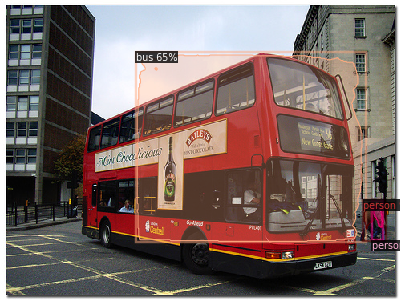

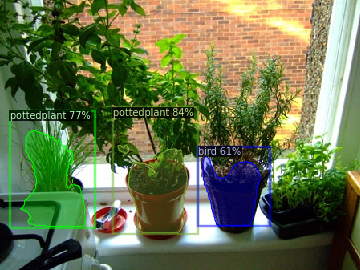

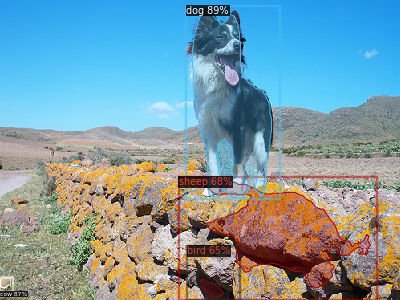

In [15]:
cfg.MODEL.WEIGHTS = '/content/output/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.DATASETS.TEST = ("V")
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dataset_dicts, 3):    
    image = cv2.imread(d["file_name"])
    outputs = predictor(image)
    v = Visualizer(image[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW  
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])